In [1]:
# Importing libraries and modules
import sklearn as sk
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix as cm
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier 
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# Reading in data
data = pd.read_csv('data.csv')
data.shape

(353, 95)

In [2]:
# First, wel will try modelling using OLS. However, we need to first choose which features will be included in the model.
# We can try using the filter method of feature selection, i.e. filtering using the pearson correlation coefficient

# Defining correlation function and target variable
cor = data.corr()
cor_target = abs(cor["Pct_Leave"])

# Selecting highly correlated features
relevant_features = cor_target[cor_target>0.50] #setting to >0.5 introduces 8 more features, making confusion matrix difficult to read
relevant_features

Pct_Remain                  1.000000
Pct_Leave                   1.000000
outcome                     0.802103
EU_2001Migrantshare         0.539331
MEP_UKIPPct                 0.868934
MEP_GreenPct                0.582164
MEP_BNPPct                  0.546850
noqual_2001_sh              0.690455
quall3_2001_sh              0.537298
quall4plus_2001_sh          0.781153
quall1_sh_growth            0.524305
quall3_sh_growth            0.716437
ind2001_Manufacturing_sh    0.564240
ind2001_Construction_sh     0.517611
ind2001_Retail_sh           0.686643
Ownedshare2001              0.506894
MigrantOldEUMemberGrowth    0.522613
InitialOldEUMember          0.539331
Name: Pct_Leave, dtype: float64

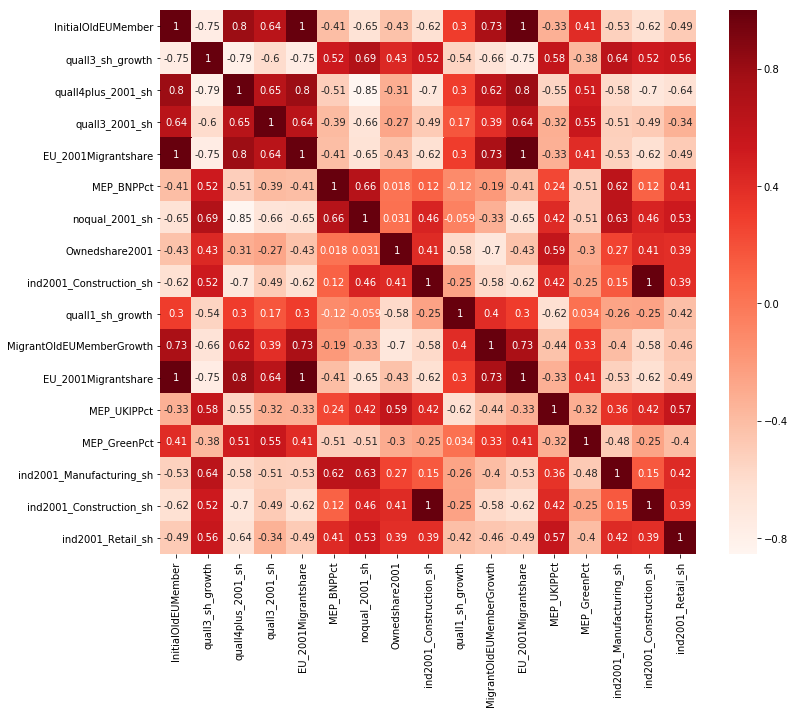

In [3]:
# Next, we generate correlation coefficients; highly correlated features cause highly biased OLS models.
# Correlation of above approximate +/- 0.5 indicates strong correlation. 

PCOLS = data[['InitialOldEUMember', 'quall3_sh_growth', 'quall4plus_2001_sh', 'quall3_2001_sh', 'EU_2001Migrantshare', 
              'MEP_BNPPct', 'noqual_2001_sh', 'Ownedshare2001', 'ind2001_Construction_sh','quall1_sh_growth',
              'MigrantOldEUMemberGrowth', 'EU_2001Migrantshare', 'MEP_UKIPPct', 'MEP_GreenPct', 'ind2001_Manufacturing_sh',
              'ind2001_Construction_sh', 'ind2001_Retail_sh',]]

plt.figure(figsize=(12,10))
PCHM = PCOLS.corr()
sns.heatmap(PCHM, annot=True, cmap=plt.cm.Reds)
plt.show()

In [4]:
# We can build a model of increasing complexity, using the most relevant variables first
# However, one of the assumptions of linear regression is that independent variables are not correlated
# Therefore, we will check for correlation between the above variables (excluding outcome, Pct_remain, etc)
# We will build a data frame with the above features, and generate a confusion matrix

# 'quall4plus_2001_sh' and 'quall3_sh_growth' highly correlated with UKIP feature
# UKIP feature has more explanatory power, so these two will be removed

# 'noqual_2001_sh' highly correlated with 'MEP_GreenPct', 'quall3_2001_sh', and 'ind2001_Manufacturing_sh'
# therefore, it will also be removed

# 'MEP_BNPPct' highly correlated with feature for green party and 'quall3_2001_sh', both of which have more explanatory power
# therefore, BNP variable will be dropped

# 'quall3_2001_sh' highly correlated with features for EU migration and Green Party, both of which have more explanatory power
#therefore, 'quall3_2001_sh' will be dropped

# 'InitialOldEUMember' perfectly correlated with EU migration feature, and will therefore be dropped

# 'MigrantOldEUMemberGrowth' very highly correlated with EU migration feature, and will therefore be dropped

# 'quall1_sh_growth' is relatively correlated with one other variable (MEP_UKIPPct); this seems acceptable

# 'ind2001_Construction_sh' is relatively correlated with the two EU variables, but will be left in

# 'Ownedshare2001' is highly correlated with 3 other variables, and will therefore be removed

   train_mse   test_mse
0  20.604648  21.882324
1  16.548425  14.554109
2  16.548425  14.554109
3  14.459838  14.184574
4  13.948053  14.258016
5  13.275279  13.662074


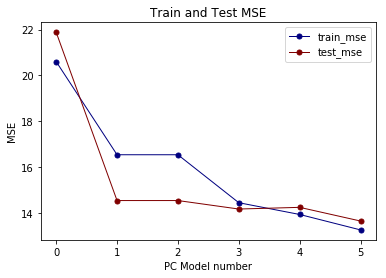

In [5]:
# Now, we will build an OLS model of increasing complexity, beginning with the most relevent variable.
# We will then compare the performance of different models.

regr = linear_model.LinearRegression()

# Model of order 2

XPC2 = data[['MEP_UKIPPct', 'ind2001_Retail_sh']]
YPC2 = data['Pct_Leave']
XPC2_train, XPC2_test, YPC2_train, YPC2_test = train_test_split(XPC2, YPC2, test_size=0.33, random_state=1)
PC2 = regr.fit(XPC2_train, YPC2_train)

# Generate test and training SE and MSE

PC2trainpred = PC2.predict(XPC2_train)
PC2train_se= (((PC2trainpred)-(YPC2_train))**2)
PC2train_mse= (PC2train_se.sum()/236)

PC2testpred = PC2.predict(XPC2_test)
PC2test_se= (((PC2testpred)-(YPC2_test))**2)
PC2test_mse= (PC2test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC2b_test=np.where(YPC2_test > 50, True, False)
YPC2b_pred=np.where(PC2testpred > 50, True, False)
YPC2bcnf_matrix = metrics.confusion_matrix(YPC2b_test, YPC2b_pred)

# Model of order 3

XPC3 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh']]
YPC3 = data['Pct_Leave']
XPC3_train, XPC3_test, YPC3_train, YPC3_test = train_test_split(XPC3, YPC3, test_size=0.33, random_state=1)
PC3 = regr.fit(XPC3_train, YPC3_train)
PC3pred = PC3.predict(XPC3_test)

# # Generate test and training SE and MSE

PC3trainpred = PC3.predict(XPC3_train)
PC3train_se= (((PC3trainpred)-(YPC3_train))**2)
PC3train_mse= (PC3train_se.sum()/236)

PC3testpred = PC3.predict(XPC3_test)
PC3test_se= (((PC3testpred)-(YPC3_test))**2)
PC3test_mse= (PC3test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC3b_test=np.where(YPC3_test > 50, True, False)
YPC3b_pred=np.where(PC3testpred > 50, True, False)
YPC3bcnf_matrix = metrics.confusion_matrix(YPC3b_test, YPC3b_pred)

# Model of order 4

XPC4 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh']]
YPC4 = data['Pct_Leave']
XPC4_train, XPC4_test, YPC4_train, YPC4_test = train_test_split(XPC4, YPC4, test_size=0.33, random_state=1)
PC4 = regr.fit(XPC4_train, YPC4_train)
PC4pred = PC4.predict(XPC4_test)

# Generate test and training SE and MSE

PC4trainpred = PC4.predict(XPC4_train)
PC4train_se= (((PC4trainpred)-(YPC4_train))**2)
PC4train_mse= (PC4train_se.sum()/236)

PC4testpred = PC4.predict(XPC4_test)
PC4test_se= (((PC4testpred)-(YPC4_test))**2)
PC4test_mse= (PC4test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC4b_test=np.where(YPC4_test > 50, True, False)
YPC4b_pred=np.where(PC4testpred > 50, True, False)
YPC4bcnf_matrix = metrics.confusion_matrix(YPC4b_test, YPC4b_pred)

# Model of order 5

XPC5 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare']]
YPC5 = data['Pct_Leave']
XPC5_train, XPC5_test, YPC5_train, YPC5_test = train_test_split(XPC5, YPC5, test_size=0.33, random_state=1)
PC5 = regr.fit(XPC5_train, YPC5_train)
PC5pred = PC5.predict(XPC5_test)

# Generate test and training SE and MSE

PC5trainpred = PC5.predict(XPC5_train)
PC5train_se= (((PC5trainpred)-(YPC5_train))**2)
PC5train_mse= (PC5train_se.sum()/236)

PC5testpred = PC5.predict(XPC5_test)
PC5test_se= (((PC5testpred)-(YPC5_test))**2)
PC5test_mse= (PC5test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC5b_test=np.where(YPC5_test > 50, True, False)
YPC5b_pred=np.where(PC5testpred > 50, True, False)
YPC5bcnf_matrix = metrics.confusion_matrix(YPC5b_test, YPC5b_pred)

# Model of order 6

XPC6 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth']]
YPC6 = data['Pct_Leave']
XPC6_train, XPC6_test, YPC6_train, YPC6_test = train_test_split(XPC6, YPC6, test_size=0.33, random_state=1)
PC6 = regr.fit(XPC6_train, YPC6_train)
PC6pred = PC6.predict(XPC6_test)

# Generate test and training SE and MSE

PC6trainpred = PC6.predict(XPC6_train)
PC6train_se= (((PC6trainpred)-(YPC6_train))**2)
PC6train_mse= (PC6train_se.sum()/236)

PC6testpred = PC6.predict(XPC6_test)
PC6test_se= (((PC6testpred)-(YPC6_test))**2)
PC6test_mse= (PC6test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC6b_test=np.where(YPC6_test > 50, True, False)
YPC6b_pred=np.where(PC6testpred > 50, True, False)
YPC6bcnf_matrix = metrics.confusion_matrix(YPC6b_test, YPC6b_pred)

# Model of order 7

XPC7 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth', 'ind2001_Construction_sh']]
YPC7 = data['Pct_Leave']
XPC7_train, XPC7_test, YPC7_train, YPC7_test = train_test_split(XPC7, YPC7, test_size=0.33, random_state=1)
PC7 = regr.fit(XPC7_train, YPC7_train)
PC7pred = PC7.predict(XPC7_test)

# Generate test and training SE and MSE

PC7trainpred = PC7.predict(XPC7_train)
PC7train_se= (((PC7trainpred)-(YPC7_train))**2)
PC7train_mse= (PC7train_se.sum()/236)

PC7testpred = PC7.predict(XPC7_test)
PC7test_se= (((PC7testpred)-(YPC7_test))**2)
PC7test_mse= (PC7test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC7b_test=np.where(YPC7_test > 50, True, False)
YPC7b_pred=np.where(PC7testpred > 50, True, False)
YPC7bcnf_matrix = metrics.confusion_matrix(YPC7b_test, YPC7b_pred)

# Collecting all test and traing mean square errors

PCtrain_mse = [(PC2train_mse), (PC3train_mse), (PC4train_mse), (PC5train_mse), (PC6train_mse), (PC7train_mse)]
PCtest_mse = [(PC2test_mse), (PC3test_mse), (PC4test_mse), (PC5test_mse), (PC6test_mse), (PC7test_mse)]

PCmse={'train_mse': PCtrain_mse, 'test_mse': PCtest_mse}
PCmse=pd.DataFrame(data=PCmse)
print(PCmse)

# Plotting MSE against model complexity

PCMSEplot = PCmse.plot(lw=1,colormap='jet',marker='o',markersize=5,title='Train and Test MSE', )
PCMSEplot.set_xlabel("PC Model number")
PCMSEplot.set_ylabel("MSE")
plt.show()

In [6]:
# Given that the model with 7 variables performs best the other will be dropped
# Summary of model performance:

print("Confusion matrix, OLS 7 variables:")
print(YPC7bcnf_matrix)
print("Accuracy, 7 variables:",metrics.accuracy_score(YPC7b_test, YPC7b_pred))
print("Precision, 7 variables:",metrics.precision_score(YPC7b_test, YPC7b_pred))
print("Recall, 7 variables:",metrics.recall_score(YPC7b_test, YPC7b_pred))

Confusion matrix, OLS 7 variables:
[[29  8]
 [ 6 74]]
Accuracy, 7 variables: 0.8803418803418803
Precision, 7 variables: 0.9024390243902439
Recall, 7 variables: 0.925


In [7]:
# Model of order 7

XPC7 = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth', 'ind2001_Construction_sh']]
YPC7 = data['Pct_Leave']
XPC7_train, XPC7_test, YPC7_train, YPC7_test = train_test_split(XPC7, YPC7, test_size=0.33, random_state=1)
PC7 = regr.fit(XPC7_train, YPC7_train)
PC7pred = PC7.predict(XPC7_test)

# Generate test and training SE and MSE

PC7trainpred = PC7.predict(XPC7_train)
PC7train_se= (((PC7trainpred)-(YPC7_train))**2)
PC7train_mse= (PC7train_se.sum()/236)

PC7testpred = PC7.predict(XPC7_test)
PC7test_se= (((PC7testpred)-(YPC7_test))**2)
PC7test_mse= (PC7test_se.sum()/117)

# Convert to binary for confusion matrix/performance metrics

YPC7b_test=np.where(YPC7_test > 50, True, False)
YPC7b_pred=np.where(PC7testpred > 50, True, False)
YPC7bcnf_matrix = metrics.confusion_matrix(YPC7b_test, YPC7b_pred)

In [8]:
# Alternatively, we can use the wrapper method of feature selection. First, we will try backwards elimination

BEX = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain',
                 'Pct_Leave','Pct_Rejected', 'outcome'], axis=1)
BEY = data['Pct_Leave']

#Adding constant column of ones, mandatory for sm.OLS model
BEX_1 = sm.add_constant(BEX)
#Fitting sm.OLS model
model = sm.OLS(BEY, BEX_1).fit()
pvalues = model.pvalues
BErelevant_features = pvalues[pvalues<0.05]
print(BErelevant_features)

mean_hourly_pay_growth      6.863619e-03
MEP_ConPct                  1.737276e-02
MEP_UKIPPct                 5.998652e-20
MEP_GreenPct                1.776009e-09
MEP_BNPPct                  6.809928e-17
TREATED_WITHIN_62_DAYS      3.603619e-02
life_sat_mean               3.557576e-02
life_sat_cv                 8.303943e-03
noqual_2001_sh              1.820646e-02
quall1_2001_sh              1.820782e-02
quall2_2001_sh              1.820796e-02
quall3_2001_sh              1.820653e-02
quall4plus_2001_sh          1.820589e-02
ind2001_Mining_sh           1.069212e-03
ManufacturingShareGrowth    3.755258e-02
TransportShareGrowth        9.972395e-03
CouncilRented2001           2.013490e-02
dtype: float64


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


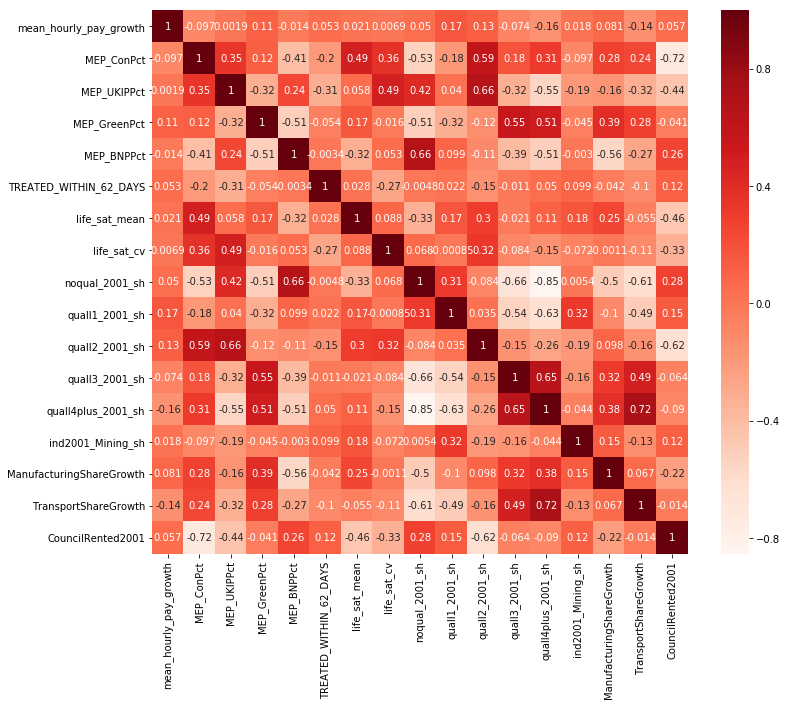

In [9]:
# Again, we generate a confusion heatmap to easily view correlations, which violate OLS assumptions

BEF = data[['mean_hourly_pay_growth', 'MEP_ConPct', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv', 'noqual_2001_sh', 'quall1_2001_sh', 'quall2_2001_sh', 'quall3_2001_sh',
           'quall4plus_2001_sh', 'ind2001_Mining_sh', 'ManufacturingShareGrowth', 'TransportShareGrowth', 'CouncilRented2001']]

plt.figure(figsize=(12,10))
BEHM = BEF.corr()
sns.heatmap(BEHM, annot=True, cmap=plt.cm.Reds)
plt.show()

In [10]:
# 'quall4plus_2001_sh' highly correlated with several variables, will be removed
# 'MEP_ConPct' highly correlated with a few variables, will be removed 
# 'noqual_2001_sh' highly correlated with a few variables, will be removed
# 'quall2_2001_sh' highly correlated with a few variables, will be removed
# 'quall3_2001_sh' highly correlated with a few variables, will be removed
# NB: Features (above) with less explanatory have been removed first

BEX = data[['mean_hourly_pay_growth', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv',  'quall1_2001_sh','ind2001_Mining_sh', 'ManufacturingShareGrowth',
           'TransportShareGrowth', 'CouncilRented2001']]
BEY = data[['Pct_Leave']]

BEX_train, BEX_test, BEY_train, BEY_test = train_test_split(BEX, BEY, test_size=0.33, random_state=1)
BE = regr.fit(BEX_train, BEY_train)
BEYpred = BE.predict(BEX_test)

# Calculate SE and MSE

BEYtrainpred = BE.predict(BEX_train)
BEtrain_se= (((BEYtrainpred)-(BEY_train))**2)
BEtrain_mse= (BEtrain_se.sum()/236)
BEtrain_mse

BEYtestpred = BE.predict(BEX_test)
BEtest_se= (((BEYtestpred)-(BEY_test))**2)
BEtest_mse= (BEtest_se.sum()/117)
BEtest_mse

# Changing to binary for confusion matrix
BEYc_test=np.where(BEY_test > 50, True, False)
BEYc_pred=np.where(BEYpred > 50, True, False)
BEcnf_matrix = metrics.confusion_matrix(BEYc_test, BEYc_pred)

print("Backwards induction, confusion matrix:")
print(BEcnf_matrix)
print("")
print("Accuracy, backward induction:",metrics.accuracy_score(BEYc_test, BEYc_pred))
print("Precision, backwards induction:",metrics.precision_score(BEYc_test, BEYc_pred))
print("Recall, backwards induction:",metrics.recall_score(BEYc_test, BEYc_pred))
print("Backwards induction, training MSE:", BEtrain_mse)
print("Backwards induction, test MSE:", BEtest_mse)

Backwards induction, confusion matrix:
[[31  6]
 [ 4 76]]

Accuracy, backward induction: 0.9145299145299145
Precision, backwards induction: 0.926829268292683
Recall, backwards induction: 0.95
Backwards induction, training MSE: Pct_Leave    6.078881
dtype: float64
Backwards induction, test MSE: Pct_Leave    9.08286
dtype: float64


In [11]:
# Choosing deatures using backwards induction produces a model which performs better than the other OLS models, and has a
# smaller MSE for both training and test datasets. However, the auc score is relatively low, implying the overall accuracy
# of the model is relatively low. 

In [12]:
# Next, we try recursive feature elimination

model = LinearRegression()
#Initializing RFE model
rfe = RFE(model, 7)
RFEX = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain','Pct_Leave','Pct_Rejected', 'outcome'], axis=1)
RFEY = data['Pct_Leave']

#Transforming data using RFE
X_RFE = rfe.fit_transform(RFEX, RFEY)

#Fitting the data to model
model.fit(X_RFE, RFEY)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False  True False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False  True  True  True False False False  True False  True False False
 False False False False False False False False False False False False
 False False]
[35 64  9  8 10 65 63 43 31  1 20  6 48 76 68 72 77 66 75 71 58 61 41 27
 78 73 54 55  4  2  5  3  1 13 16 12 14 15 36 22 47 25 39 40 49 29 60 28
 33 21 38 26 23 24 11 46 32 34 57 53 67  1  1  1 19 18  7  1 17  1 56 59
 52 74 42 79 30 70 62 51 50 69 44 80 37 45]


In [13]:
# In the above array, 'True' reflects that a feature is relevant; there are 7 of these entries, meaning 7 relevant features.
# We use this to calculate the number of optimum features.

#no of features
nof_list=np.arange(1,7)            
high_score=0

#Variable to store the optimum features
nof=0           
score_list =[]
for n in range(len(nof_list)):
    RFEX_train, RFEX_test, RFEY_train, RFEY_test = train_test_split(RFEX, RFEY, test_size = 0.3, random_state = 0)
    model = LinearRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(RFEX_train, RFEY_train)
    X_test_rfe = rfe.transform(RFEX_test)
    model.fit(X_train_rfe, RFEY_train)
    score = model.score(X_test_rfe, RFEY_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 5
Score with 5 features: 0.272990


In [14]:
cols = list(RFEX.columns)
model = LinearRegression()

#Initializing RFE model
rfe = RFE(model, 5)       

#Transforming data using RFE
X_rfe = rfe.fit_transform(RFEX, RFEY) 

#Fitting the data to model
model.fit(X_rfe, RFEY)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['NONEU_2001Migrantshare', 'PublicEmployment2014',
       'PublicEmploymentGrowth', 'InitialEUAccession', 'InitialElsewhere'],
      dtype='object')


In [15]:
RFX = data[['NONEU_2001Migrantshare', 'PublicEmployment2014', 'PublicEmploymentGrowth', 'InitialEUAccession',
           'InitialElsewhere']]
RFY = data[['Pct_Leave']]

RFX_train, RFX_test, RFY_train, RFY_test = train_test_split(RFX, RFY, test_size=0.33, random_state=1)
RF = regr.fit(RFX_train, RFY_train)
RFYpred = RF.predict(RFX_test)

# Calculate SE and MSE

RFYtrainpred = RF.predict(RFX_train)
RFYtrain_se= (((RFYtrainpred)-(RFY_train))**2)
RFYtrain_mse= (RFYtrain_se.sum()/236)
RFYtrain_mse

RFYtestpred = RF.predict(RFX_test)
RFYtest_se= (((RFYtestpred)-(RFY_test))**2)
RFYtest_mse= (RFYtest_se.sum()/117)
RFYtest_mse

# Changing to binary for confusion matrix
RFYd_test=np.where(RFY_test > 50, True, False)
RFYd_pred=np.where(RFYpred > 50, True, False)
RFcnf_matrix = metrics.confusion_matrix(RFYd_test, RFYd_pred)

print("Recursive feature elimination, confusion matrix:")
print(RFcnf_matrix)
print("")
print("Accuracy, Recursive feature elimination:",metrics.accuracy_score(RFYd_test, RFYd_pred))
print("Precision, Recursive feature elimination:",metrics.precision_score(RFYd_test, RFYd_pred))
print("Recall, Recursive feature elimination:",metrics.recall_score(RFYd_test, RFYd_pred))
print("Backwards Recursive feature elimination MSE:", RFYtrain_mse)
print("Backwards Recursive feature elimination MSE:", RFYtest_mse)

Recursive feature elimination, confusion matrix:
[[14 23]
 [ 7 73]]

Accuracy, Recursive feature elimination: 0.7435897435897436
Precision, Recursive feature elimination: 0.7604166666666666
Recall, Recursive feature elimination: 0.9125
Backwards Recursive feature elimination MSE: Pct_Leave    75.618256
dtype: float64
Backwards Recursive feature elimination MSE: Pct_Leave    80.063072
dtype: float64


In [16]:
# Recursive feature selection produces a model with relatively high recall, but very poor accuracy and precision. Additionally,
# it has high training and test MSE relative to other models, and a very low auc score.

In [17]:
# Finally, we will try an embedded method of feature selection (regularisation); in this instance, we will be using
# Lasso regularisation. This involves the systematic shrinkage of OLS coefficients; this reduces the risk of overfitting
# but imposes higher bias. However, given the very large number of features, and very high risk of overfitting, this seems
# like an acceptable trade-off. 

LX1 = data.drop(['Pct_Turnout','Votes_Cast', 'Valid_Votes', 'Remain', 'Leave','Pct_Remain','Pct_Leave','Pct_Rejected'], axis=1)
LY1 = data['Pct_Leave']

Lreg = LassoCV()
Lreg.fit(LX1, LY1)
print("Best alpha using built-in LassoCV: %f" % Lreg.alpha_)
print("Best score using built-in LassoCV: %f" %Lreg.score(LX1, LY1))
Lcoef = pd.Series(Lreg.coef_, index = LX1.columns)

print("Lasso picked " + str(sum(Lcoef != 0)) + " variables and eliminated the other " +  str(sum(Lcoef == 0)) + " variables; the variables it picked are:")
print("")

# Picking out best Lasso variables
imp_Lcoef = Lcoef.sort_values()
print(imp_Lcoef.head(6))
print("")
print(imp_Lcoef.tail(8))

Best alpha using built-in LassoCV: 0.176358
Best score using built-in LassoCV: 0.938775
Lasso picked 12 variables and eliminated the other 75 variables; the variables it picked are:

median_hourly_pay2005    -0.981513
MEP_GreenPct             -0.746376
TREATED_WITHIN_62_DAYS   -0.041781
MEP_LDPct                -0.023797
MEP_ConPct               -0.006219
PublicEmployment2009      0.000000
dtype: float64

quall4plus_sh_growth             -0.000000
TotalImpactFLWAAYR                0.001122
self_employment_rate_aps          0.004665
MEP_Turnout                       0.037896
economic_activity_rate_aps2015    0.059973
umemployment_rate_aps             0.114250
MEP_UKIPPct                       0.765591
MEP_BNPPct                        2.724853
dtype: float64


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
LX = data[['median_hourly_pay2005', 'MEP_GreenPct', 'TREATED_WITHIN_62_DAYS', 'MEP_LDPct', 'MEP_ConPct',
           'TotalImpactFLWAAYR', 'self_employment_rate_aps', 'MEP_Turnout', 'economic_activity_rate_aps2015',
           'umemployment_rate_aps', 'MEP_UKIPPct', 'MEP_BNPPct']]

LY = data[['Pct_Leave']]


LX_train, LX_test, LY_train, LY_test = train_test_split(LX, LY, test_size=0.33, random_state=1)
LY = regr.fit(LY_train, LX_train)

In [19]:
# We will now generate this model and check its performance

LX = data[['median_hourly_pay2005', 'MEP_GreenPct', 'TREATED_WITHIN_62_DAYS', 'MEP_LDPct', 'MEP_ConPct',
           'TotalImpactFLWAAYR', 'self_employment_rate_aps', 'MEP_Turnout', 'economic_activity_rate_aps2015',
           'umemployment_rate_aps', 'MEP_UKIPPct', 'MEP_BNPPct']]

LY = data[['Pct_Leave']]


LX_train, LX_test, LY_train, LY_test = train_test_split(LX, LY, test_size=0.33, random_state=1)
L = regr.fit(LX_train, LY_train)

# Calculate SE and MSE

Ltrainpred = L.predict(LX_train)
Ltrain_se= (((Ltrainpred)-(LY_train))**2)
Ltrain_mse= (Ltrain_se.sum()/236)

Ltestpred = L.predict(LX_test)
Ltest_se= (((Ltestpred)-(LY_test))**2)
Ltest_mse= (Ltest_se.sum()/117)


# Changing to binary for confusion matrix
Le_test=np.where(LY_test > 50, True, False)
Le_pred=np.where(Ltestpred > 50, True, False)
LYcnf_matrix = metrics.confusion_matrix(Le_test, Le_pred)

print("Lasso method, confusion matrix:")
print(LYcnf_matrix)
print("")
print("Accuracy, Lasso method:",metrics.accuracy_score(Le_test, Le_pred))
print("Precision, Lasso method:",metrics.precision_score(Le_test, Le_pred))
print("Recall, Lasso method:",metrics.recall_score(Le_test, Le_pred))
print("Lasso method, training MSE:", Ltrain_mse)
print("Lasso method, test MSE:", Ltest_mse)

Lasso method, confusion matrix:
[[33  4]
 [ 4 76]]

Accuracy, Lasso method: 0.9316239316239316
Precision, Lasso method: 0.95
Recall, Lasso method: 0.95
Lasso method, training MSE: Pct_Leave    6.060954
dtype: float64
Lasso method, test MSE: Pct_Leave    7.61429
dtype: float64


In [20]:
# OLS with features chosen using Lasso regularisation performs the best in terms of all performance metrics, and has the
# highest auc scores. Therefore, when using OLS to predict outcomes, features chosen using Lasso regularisation produce
# the most accurate model in term of accuracy, recall, and precision, and has the best overall accuracy, measured by the auc 
# score. However, the auc score is still less than 0.95, meaning this model violates the usual 95% confidence rule. We will now 
# generate models using logstics regression instead. We will generate models using features from the 7 feature OLS model (where
# features were chosen manually according to correlation coefficients), backwards elimination model, and lasso regulatisation
# model. 

Accuracy: 0.8717948717948718
Precision: 0.8494623655913979
Recall: 0.9875


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


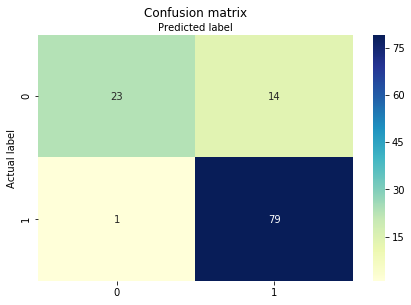

In [21]:
## First, the 7 feature OLS model: 

LR7X = data[['MEP_UKIPPct', 'ind2001_Retail_sh', 'ind2001_Manufacturing_sh', 'EU_2001Migrantshare', 'quall1_sh_growth', 'ind2001_Construction_sh']]
LR7Y = data['outcome']

LR7X_train, LR7X_test, LR7Y_train, LR7Y_test = train_test_split(LR7X, LR7Y, test_size=0.33,random_state=0)
logreg = LogisticRegression()
logreg.fit(LR7X_train, LR7Y_train)
LR7Y_pred=logreg.predict(LR7X_test)

LR7cnf_matrix = metrics.confusion_matrix(LR7Y_test, LR7Y_pred)
LR7cnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(LR7cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(LR7Y_test, LR7Y_pred))
print("Precision:",metrics.precision_score(LR7Y_test, LR7Y_pred))
print("Recall:",metrics.recall_score(LR7Y_test, LR7Y_pred))

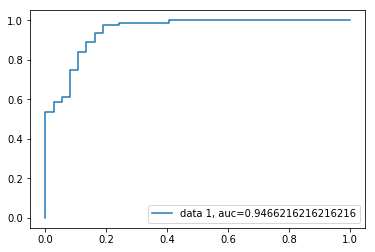

In [22]:
# Generating 7 feature ROC curve

LR7Y_pred_proba = logreg.predict_proba(LR7X_test)[::,1]
LR7fpr, LR7tpr, _ = metrics.roc_curve(LR7Y_test,  LR7Y_pred_proba)
LR7auc = metrics.roc_auc_score(LR7Y_test, LR7Y_pred_proba)
plt.plot(LR7fpr,LR7tpr,label="data 1, auc="+str(LR7auc))
plt.legend(loc=4)
plt.show()

# auc score is greater that 0.93
# auc score of 1 implies perfect classifier; auc score of 0.5 implies worthless classifier
# LR is prone to overfitting models; given the high number of explanatory variables, and given that auc score is very high
# despite small training sample, it seems likely this LR model is also overfitting the data. 

In [23]:
# Compared to the 7 feature OLS model, the 7 feature logistic regression model has much higher recall, but lower accuracy and
# precision; this implies the model is overfitted, and would probably not be a good predictor. 

Accuracy: 0.9316239316239316
Precision: 0.9615384615384616
Recall: 0.9375


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


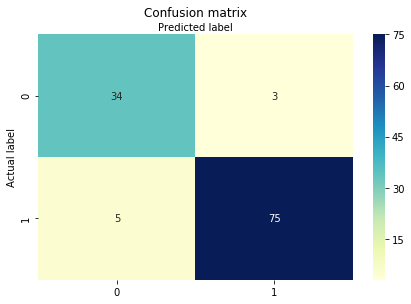

In [24]:
# Next, we will use features from the backwards induction model:

LRBEX = data[['mean_hourly_pay_growth', 'MEP_UKIPPct', 'MEP_GreenPct', 'MEP_BNPPct', 'TREATED_WITHIN_62_DAYS',
           'life_sat_mean', 'life_sat_cv',  'quall1_2001_sh','ind2001_Mining_sh', 'ManufacturingShareGrowth',
           'TransportShareGrowth', 'CouncilRented2001']]
LRBEY = data[['outcome']]

LRBEX_train, LRBEX_test, LRBEY_train, LRBEY_test = train_test_split(LRBEX, LRBEY, test_size=0.33,random_state=0)
logreg.fit(LRBEX_train, LRBEY_train)
LRBEY_pred=logreg.predict(LRBEX_test)

LRBEcnf_matrix = metrics.confusion_matrix(LRBEY_test, LRBEY_pred)
LRBEcnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(LRBEcnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(LRBEY_test, LRBEY_pred))
print("Precision:",metrics.precision_score(LRBEY_test, LRBEY_pred))
print("Recall:",metrics.recall_score(LRBEY_test, LRBEY_pred))

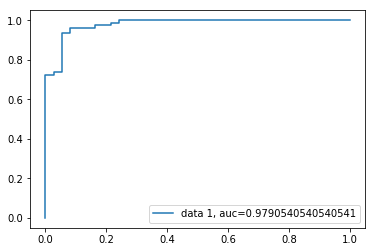

In [25]:
# Generating backwards induction ROC curve

LRBEY_pred_proba = logreg.predict_proba(LRBEX_test)[::,1]
LRBEfpr, LRBEtpr, _ = metrics.roc_curve(LRBEY_test,  LRBEY_pred_proba)
LRBEauc = metrics.roc_auc_score(LRBEY_test, LRBEY_pred_proba)
plt.plot(LRBEfpr,LRBEtpr,label="data 1, auc="+str(LRBEauc))
plt.legend(loc=4)
plt.show()

# auc score is greater that 0.93
# auc score of 1 implies perfect classifier; auc score of 0.5 implies worthless classifier
# LR is prone to overfitting models; given the high number of explanatory variables, and given that auc score is very high
# despite small training sample, it seems likely this LR model is also overfitting the data. 

In [26]:
# Logistic regression with features chosen through backwards elimination produces extremely high recall with similarly high
# accuracy and precision, and a very high auc score. This is the best performing model so far. 

Accuracy: 0.9401709401709402
Precision: 0.9620253164556962
Recall: 0.95


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


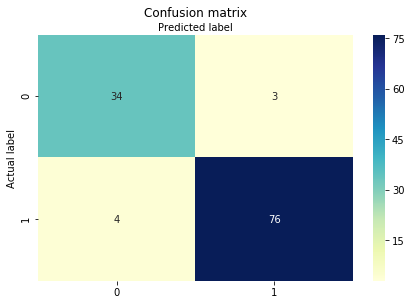

In [27]:
# Next, we will use features from the Lasso model:

LRLX = data[['median_hourly_pay2005', 'MEP_GreenPct', 'TREATED_WITHIN_62_DAYS', 'MEP_LDPct', 'MEP_ConPct',
           'TotalImpactFLWAAYR', 'self_employment_rate_aps', 'MEP_Turnout', 'economic_activity_rate_aps2015',
           'umemployment_rate_aps', 'MEP_UKIPPct', 'MEP_BNPPct']]

LRLY = data[['outcome']]

LRLX_train, LRLX_test, LRLY_train, LRLY_test = train_test_split(LRLX, LRLY, test_size=0.33,random_state=0)
logreg.fit(LRLX_train, LRLY_train)
LRLY_pred=logreg.predict(LRLX_test)

LRLcnf_matrix = metrics.confusion_matrix(LRLY_test, LRLY_pred)
LRLcnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(LRLcnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Accuracy:",metrics.accuracy_score(LRLY_test, LRLY_pred))
print("Precision:",metrics.precision_score(LRLY_test, LRLY_pred))
print("Recall:",metrics.recall_score(LRLY_test, LRLY_pred))

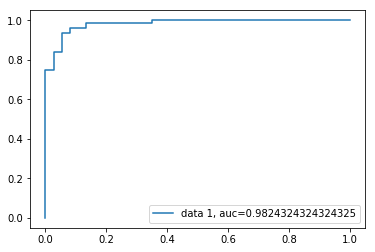

In [28]:
# Generating backwards induction ROC curve

LRLY_pred_proba = logreg.predict_proba(LRLX_test)[::,1]
LRLfpr, LRLtpr, _ = metrics.roc_curve(LRLY_test,  LRLY_pred_proba)
LRLauc = metrics.roc_auc_score(LRLY_test, LRLY_pred_proba)
plt.plot(LRLfpr,LRLtpr,label="data 1, auc="+str(LRLauc))
plt.legend(loc=4)
plt.show()

# auc score is greater that 0.93
# auc score of 1 implies perfect classifier; auc score of 0.5 implies worthless classifier
# LR is prone to overfitting models; given the high number of explanatory variables, and given that auc score is very high
# despite small training sample, it seems likely this LR model is also overfitting the data. 

In [29]:
# The logistic regression model with features chosen through Lasso regularisation performs as well as the logistic regression
# model with features chosen through backwards induction in terms of accuracy, recall, and precision, but has a higher auc
# score, overall making it a more accurate and superior model. Additionally, the auc score is well above the 95% rule-of-thumb
# confidence level. 

Recursive feature accuracy: 0.7094017094017094
Recursive feature precision: 0.7017543859649122
Recursive feature recall: 1.0


C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Sean\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


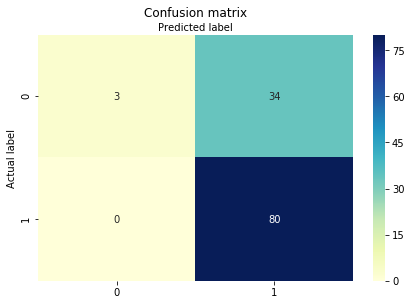

In [30]:
# Finally, we use features chosen using recursive feature selection, to see if it performs any better using logistic regression:

LRRFX = data[['NONEU_2001Migrantshare', 'PublicEmployment2014', 'PublicEmploymentGrowth', 'InitialEUAccession',
           'InitialElsewhere']]
LRRFY = data[['outcome']]

LRRFX_train, LRRFX_test, LRRFY_train, LRRFY_test = train_test_split(LRRFX, LRRFY, test_size=0.33,random_state=0)
logreg.fit(LRRFX_train, LRRFY_train)
LRRFY_pred=logreg.predict(LRRFX_test)

LRRFcnf_matrix = metrics.confusion_matrix(LRRFY_test, LRRFY_pred)
LRRFcnf_matrix

class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(pd.DataFrame(LRRFcnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

print("Recursive feature accuracy:",metrics.accuracy_score(LRRFY_test, LRRFY_pred))
print("Recursive feature precision:",metrics.precision_score(LRRFY_test, LRRFY_pred))
print("Recursive feature recall:",metrics.recall_score(LRRFY_test, LRRFY_pred))

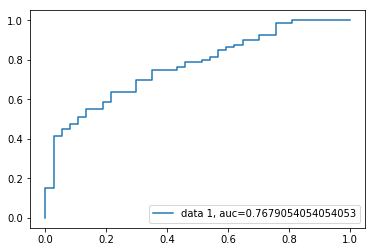

In [31]:
# Generating recursive feature ROC curve

LRRFY_pred_proba = logreg.predict_proba(LRRFX_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(LRRFY_test,  LRRFY_pred_proba)
LRRFauc = metrics.roc_auc_score(LRRFY_test, LRRFY_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(LRRFauc))
plt.legend(loc=4)
plt.show()

# auc score is greater that 0.93
# auc score of 1 implies perfect classifier; auc score of 0.5 implies worthless classifier
# LR is prone to overfitting models; given the high number of explanatory variables, and given that auc score is very high
# despite small training sample, it seems likely this LR model is also overfitting the data. 

In [32]:
# A model using features chosen through recursive selection performs even more poorly when using logstic regression.

In [33]:
# CONCLUSION/SUMMARY: